In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data/01_raw/train.csv')


In [4]:
# churn, international_plan, voice_mail_plan -> yes: 1, no: 0 변환
df['churn'] = (df['churn'] == 'yes').astype(int)
df['international_plan'] = (df['international_plan'] == 'yes').astype(int)
df['voice_mail_plan'] = (df['voice_mail_plan'] == 'yes').astype(int)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [5]:
X = df.drop(['churn', 'state','account_length','area_code'], axis=1).to_numpy()
y = df['churn'].to_numpy()
X.shape, y.shape

((4250, 16), (4250,))

In [6]:
# 딥러닝 모델링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# 스케일링 
# 분류이므로 y_scale은 생략
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
# dataset - dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size = 128, shuffle=False)

print(len(train_ds), len(test_ds)) # 데이터샘플수
print(len(train_loader), len(test_loader)) # 미니배치 회수(1epoch당)

3187 1063
25 9


In [7]:
df['churn'].value_counts()

churn
0    3652
1     598
Name: count, dtype: int64

In [ ]:
# 이진분류 torch 모델
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight

class ChurnClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),


            nn.Linear(hidden_dim, output_dim),
        )
    
    def forward(self, X):
        return self.net(X)
    
model = ChurnClassifier(input_dim=X_train.shape[-1])
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# 불균형 데이터 
neg = (y_train == 0).sum().item()
pos = (y_train == 1).sum().item()
pos_weight = torch.tensor([neg / pos], dtype=torch.float)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

summary(model, input_data=next(iter(train_loader))[0])


Layer (type:depth-idx)                   Output Shape              Param #
ChurnClassifier                          [128, 1]                  --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Linear: 2-1                       [128, 16]                 272
│    └─ReLU: 2-2                         [128, 16]                 --
│    └─Linear: 2-3                       [128, 32]                 544
│    └─ReLU: 2-4                         [128, 32]                 --
│    └─Linear: 2-5                       [128, 64]                 2,112
│    └─ReLU: 2-6                         [128, 64]                 --
│    └─Linear: 2-7                       [128, 32]                 2,080
│    └─ReLU: 2-8                         [128, 32]                 --
│    └─Linear: 2-9                       [128, 1]                  33
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.65
Input size (MB): 0.01
Forward/backward 

In [81]:
# 모델 학습
for epoch in range(30):
    model.train()
    for X_batch, y_batch in train_loader:
        # y_batch = y_batch.reshape(-1, 1)
        optimizer.zero_grad()
        output = model(X_batch)
        y_batch = y_batch.float().view(-1, 1)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

In [82]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
# 모델 평가 
model.eval()
with torch.no_grad():
    all_labels, all_preds = [],[]
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        proba = F.sigmoid(output)
        pred = (proba >= 0.5).int()
        all_labels.extend(y_batch)
        all_preds.extend(pred)

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=['churn_X','churn_O']))


[[887  26]
 [ 29 121]]
              precision    recall  f1-score   support

     churn_X       0.97      0.97      0.97       913
     churn_O       0.82      0.81      0.81       150

    accuracy                           0.95      1063
   macro avg       0.90      0.89      0.89      1063
weighted avg       0.95      0.95      0.95      1063



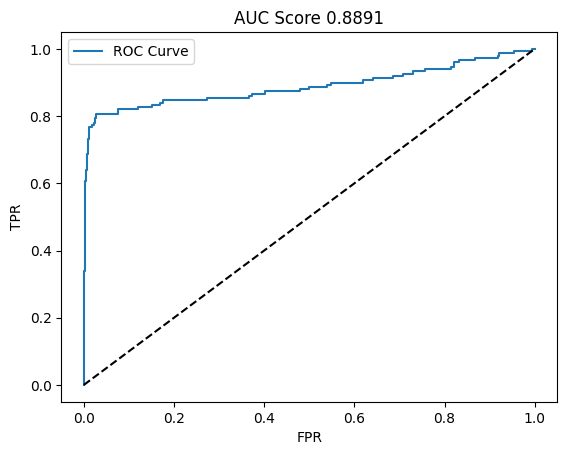

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
y_true = y_test.detach().cpu().numpy()
y_score = proba.detach().cpu().numpy()
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1],[0,1], 'k--') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title(f'AUC Score {roc_auc_score(y_true, pred):.4f}')
plt.show()
